# Data load and preprocessing

In [1]:
# read .csv into python
import pandas as pd
import numpy as np
import os
data = pd.read_csv('D:/Columbia/Fall 2018/PTA/Project/beeradvocate1.csv', sep='^', engine='python', 
                   header=None, error_bad_lines=False, warn_bad_lines=False)

In [2]:
data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

# keep 3 columns: user name, beer name, overall score
data2 = data[['beer_name', 'review_profileName', 'review_overall', 'review_time']]

m = 1000 # number of users
n = 100 # Number of items
# remove NA
data2 = data2[pd.notnull(data2.beer_name)]
data2 = data2[pd.notnull(data2.review_profileName)]
data2 = data2[pd.notnull(data2.review_overall)]
print(data2.shape)


(1585696, 4)


In [3]:
# keep top 1000/33382 frequent users
user = data2.review_profileName.value_counts()
user_list = user.keys()[:m].tolist()

# keep top 100/56855 most reviewed beer
beer = data2.beer_name.value_counts()[:200]
beer_list = beer.keys()[:n].tolist()

# keep (beer&user) pair in (user_list) and (beer_list)
subdata = data2[data2.beer_name.isin(beer_list)]
subdata = subdata[subdata.review_profileName.isin(user_list)]

# sort by user names
subdata = subdata.sort_values(by=['review_profileName','beer_name','review_time'])

print(subdata.shape)


(68895, 4)


In [4]:
#subdata.groupby(['beer_name', 'review_profileName'])['review_time'].max()

data_clean = subdata.sort_values(by='review_time')

data_clean.drop_duplicates(['beer_name', 'review_profileName'], keep = 'last',
                          inplace = True)
data_clean['review_overall'] = data_clean['review_overall'].astype(float)

data_train = data_clean.sample(frac = 0.7, random_state=1)
data_test = data_clean.drop(data_train.index)




<h1> Questions that we will be answering </h1>

- Which Matrix factorisation techniques have the lowest error when predicting beer ratings? NMF or SVD
- How does number of latent factors for matrix factorisation affect the prediction performance?
- How do the users and items' regularization parameters affect the quality of predictions for Non-Negative matrix factorisation?
- How do both SVD and NMF alogrithm scale with increase in number of users and number of items? 



In [5]:
from surprise import NMF, GridSearch, Reader, Dataset, SVD
from surprise.model_selection import GridSearchCV

In [11]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_clean[['review_profileName', 'beer_name', 'review_overall']], reader)

<h2> Non-negative Matrix Factorisation </h2>

We will compare the performance of the algorithm by experimenting with different values for parameters such as number of factors and regularisation coefficients for user and items.  

The table below summarizes the performance of the NMF with different parameters. For now, we keep the number of epochs constant.


In [12]:
# NMF - Non negative martix factorisation 
# n_factors – The number of factors. Default is 15.
# n_epochs – The number of iteration of the Stochastic gradient descent procedure.
# reg_pu – The regularization term for users λu.
# reg_qi – The regularization term for items λi.



param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [50], 'reg_pu': [0.01, 0.05, 0.1], 'reg_qi': [0.01, 0.05, 0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_nmf.fit(data)
results_df_nmf = pd.DataFrame.from_dict(grid_search_nmf.cv_results)
results_df_nmf

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi
0,0.583916,0.580959,0.582609,0.589773,0.581750,0.583801,0.003143,16,0.445836,0.445829,...,19,3.156503,0.103861,0.087135,0.040542,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.01
1,0.571013,0.566088,0.568232,0.577525,0.558603,0.568292,0.006187,12,0.436297,0.431373,...,14,2.976649,0.066271,0.069028,0.015156,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.05
2,0.568814,0.557708,0.572283,0.570379,0.556560,0.565149,0.006646,10,0.431692,0.422676,...,12,2.811017,0.034928,0.065712,0.018651,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.10
3,0.581111,0.569021,0.578583,0.573351,0.576807,0.575775,0.004217,15,0.445227,0.434824,...,16,2.789839,0.095389,0.072500,0.019540,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.01
4,0.565120,0.552589,0.564697,0.566375,0.555657,0.560887,0.005635,9,0.433057,0.418643,...,11,3.049878,0.145299,0.068659,0.013390,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.05
5,0.560491,0.547299,0.558868,0.561413,0.550722,0.555758,0.005674,6,0.427782,0.417046,...,6,3.067245,0.151589,0.069375,0.013041,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.10
6,0.570281,0.565001,0.571424,0.568784,0.561551,0.567408,0.003643,11,0.434072,0.432278,...,13,2.971163,0.057833,0.073503,0.016888,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.01
7,0.561836,0.553983,0.560744,0.559019,0.553925,0.557902,0.003346,8,0.429604,0.423430,...,9,2.786843,0.020448,0.064763,0.014552,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.05
8,0.559192,0.548076,0.562340,0.559700,0.551054,0.556073,0.005501,7,0.428480,0.418039,...,8,2.888815,0.042855,0.067159,0.014889,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.10
9,0.939518,0.924727,0.920468,0.903493,0.909311,0.919503,0.012562,30,0.769534,0.760654,...,30,3.352595,0.140337,0.079016,0.019070,"{'n_factors': 20, 'n_epochs': 50, 'reg_pu': 0....",20,50,0.01,0.01


We report the values of the parameters that achieve the lowest RMSE and MAE respectively. 

In [13]:
# For Root mean square error
print("Least root mean square error")
print(grid_search_nmf.best_score['rmse'])
print("Grid parameters")
print(grid_search_nmf.best_params['rmse'])
print("")
# For mean absolute error
print("Least mean absolute error")
print(grid_search_nmf.best_score['mae'])
print("Grid parameters")
print(grid_search_nmf.best_params['mae'])

Least root mean square error
0.5454661788791693
Grid parameters
{'n_factors': 30, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}

Least mean absolute error
0.40774144116162947
Grid parameters
{'n_factors': 30, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}


It is worth pointing out that regularization parameters of 0.1 for both users and items achieve the lowest RMSE and MAE. This could be a sign that the model is not overfitting the train data. Although, it could also be a factor of the way we selected out sample data since we are looking at the top 200 most rated beers and top 2000 users for # of reviews written. 

<h3>2. Comparing performance for different numbers of latent factors </h3>

To compare the performance of the NMF algorithm for different numbers of latent factors, we set both the regularization parameters to 0.01  

In [14]:
param_grid = {'n_factors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_nmf.fit(data)
nmf_factors = pd.DataFrame.from_dict(grid_search_nmf.cv_results)


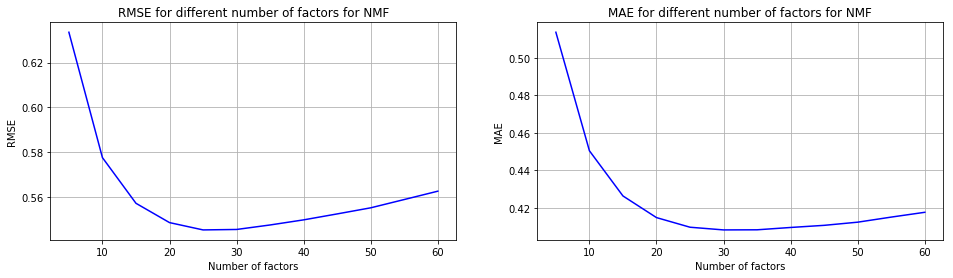

In [19]:
# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(nmf_factors.param_n_factors,nmf_factors.mean_test_rmse, 'b')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='RMSE for different number of factors for NMF')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(nmf_factors.param_n_factors,nmf_factors.mean_test_mae, 'b')
ax2.set(xlabel='Number of factors', ylabel='MAE', title='MAE for different number of factors for NMF')
ax2.grid()

plt.show()

**RMSE**: As we can see, the RMSE for a low number of factors (less than 5) is quite high as the matrix factorization is likely oversimplifying the data. As the number of factors increases, the RMSE quickly decreased and reaches a minimum at 25 factors. This is likely the optimal number of factors since with more than 25 factors the RMSE starts to increase gradually as the model begins to overfit the data.

**MAE**: Similar to the RMSE case, we see a similar trend of high MAE for low number of factors. The lowest MAE is achieved around 30 factors with the model beginning to overfit after that.

<h3>3. Comparing Regularisation Terms for NMF </h3> 

We compare the effect of different values for the regularisation parameters on prediction MAE and RMSE. This can help us understand if ratings given by users and ratings received by items need to be treated differently to prevent the model from overfitting the data.

In this case, we check the results for values lower than 0.1 unlike we did earlier. Although, we find that the optimal regularisation values for user and item are indeed 0.1 for both.

In [20]:
param_grid_pu = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.01, 0.05, 0.1, 0.25, 0.5, 1.0], 'reg_qi': [0.1]}
grid_search_pu = GridSearchCV(NMF, param_grid_pu, measures=['RMSE', 'MAE'], cv = 5)
grid_search_pu.fit(data)
results_pu = pd.DataFrame.from_dict(grid_search_pu.cv_results)
results_pu

param_grid_qi = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.01, 0.05, 0.1, 0.25, 0.5, 1.0]}
grid_search_qi = GridSearchCV(NMF, param_grid_qi, measures=['RMSE', 'MAE'], cv = 5)
grid_search_qi.fit(data)
results_qi = pd.DataFrame.from_dict(grid_search_qi.cv_results)
results_qi

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi
0,0.771874,0.766626,0.775373,0.762438,0.782152,0.771693,0.006845,6,0.607989,0.601509,...,6,3.857621,0.055740,0.081326,0.016122,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.01
1,0.568514,0.576289,0.571326,0.565289,0.572493,0.570782,0.003711,3,0.421034,0.428000,...,2,3.750698,0.128607,0.076666,0.020729,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.05
2,0.541712,0.549074,0.545435,0.537726,0.547794,0.544348,0.004152,1,0.407956,0.411302,...,1,3.654097,0.073667,0.067560,0.017251,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.10
3,0.556830,0.562623,0.562177,0.557851,0.564801,0.560856,0.003022,2,0.430894,0.431223,...,3,3.768436,0.171734,0.075307,0.020907,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.25
4,0.583109,0.586199,0.587325,0.582962,0.589382,0.585795,0.002474,4,0.461586,0.459133,...,4,3.794765,0.124550,0.077598,0.027784,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.50
5,0.623909,0.625743,0.628029,0.625849,0.630532,0.626813,0.002272,5,0.507525,0.504142,...,5,3.882451,0.127831,0.082672,0.019976,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,1.00


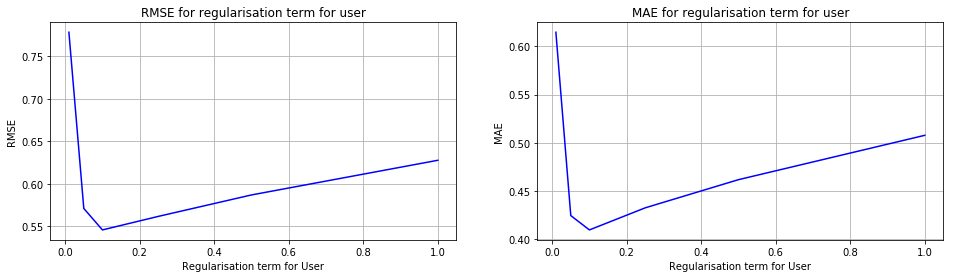

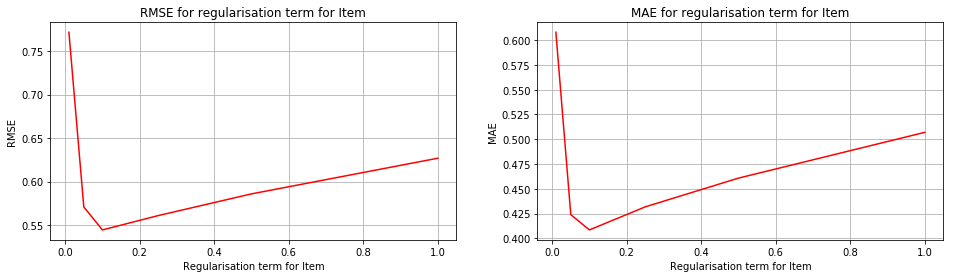

In [21]:
# RMSE and MAE comparisions for Regularisation parameters
fig = plt.figure(figsize=(16,4))

# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF

ax1 = fig.add_subplot(121)
ax1.plot(results_pu.param_reg_pu, results_pu.mean_test_rmse, 'b')
ax1.set(xlabel='Regularisation term for User', ylabel='RMSE', title='RMSE for regularisation term for user')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results_pu.param_reg_pu, results_pu.mean_test_mae, 'b')
ax2.set(xlabel='Regularisation term for User', ylabel='MAE', title='MAE for regularisation term for user')
ax2.grid()

fig2 = plt.figure(figsize=(16,4))

# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF

ax3 = fig2.add_subplot(121)
ax3.plot(results_qi.param_reg_qi, results_qi.mean_test_rmse, 'r')
ax3.set(xlabel='Regularisation term for Item', ylabel='RMSE', title='RMSE for regularisation term for Item')
ax3.grid()

ax4 = fig2.add_subplot(122)
ax4.plot(results_qi.param_reg_qi, results_qi.mean_test_mae, 'r')
ax4.set(xlabel='Regularisation term for Item', ylabel='MAE', title='MAE for regularisation term for Item')
ax4.grid()

plt.show()


The above plot shows that for both items and users, the optimal regularisation terms are 0.1. It also shows that for regularisation terms less than 0.1, the RMSE and MAE increase is exponential compared to the the regularisation terms being more than 0.1. 


<h2>Singular Value Decomposition</h2>

Similar to our NMF approach,  wecompare the performance of the algorithm by experimenting with different values for parameters such as number of factors learning rate.  

The table below summarizes the performance of the NMF with different parameters. For now, we keep the number of epochs constant.

In [22]:
# SVD - Singular Value Decomposition
# n_factors – The number of factors. Default is 100.
# n_epochs – The number of iteration of the SGD procedure. Default is 20.
# lr_all – The learning rate for all parameters. Default is 0.005.
# reg_all – The regularization term for all parameters. Default is 0.02.


param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [50], 'lr_all': [0.01, 0.05, 0.1], 'reg_all': [0.01, 0.05, 0.1]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search_svd.fit(data)
results_svd = pd.DataFrame.from_dict(grid_search_svd.cv_results)
results_svd

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
0,0.588403,0.591805,0.585975,0.601221,0.581489,0.589779,0.006635,25,0.438036,0.439747,...,25,2.665895,0.046812,0.085331,0.022894,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.01
1,0.533449,0.539435,0.529895,0.548310,0.533818,0.536981,0.006435,4,0.399677,0.402582,...,4,2.635210,0.072017,0.073407,0.016760,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.05
2,0.537483,0.542799,0.535381,0.551187,0.537764,0.540923,0.005682,8,0.402928,0.405614,...,8,2.614830,0.049191,0.073770,0.017885,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.10
3,0.632507,0.632983,0.635212,0.645854,0.636342,0.636580,0.004847,29,0.469646,0.469287,...,29,2.627668,0.078214,0.082043,0.023955,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.01
4,0.546993,0.555844,0.548307,0.562233,0.549283,0.552532,0.005730,16,0.411589,0.414611,...,16,2.582393,0.032293,0.072134,0.018325,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.05
5,0.540686,0.548477,0.540603,0.557328,0.542174,0.545854,0.006424,12,0.406046,0.410778,...,12,2.606852,0.043643,0.072354,0.016925,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.10
6,0.650260,0.648192,0.647742,0.669131,0.655287,0.654122,0.007968,30,0.486183,0.483122,...,30,2.590009,0.027800,0.083131,0.025083,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.01
7,0.559651,0.568870,0.561272,0.578270,0.563778,0.566368,0.006719,24,0.421938,0.427106,...,23,2.582369,0.041296,0.078024,0.016545,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.05
8,0.555275,0.560969,0.555162,0.571724,0.555982,0.559822,0.006326,20,0.417919,0.422022,...,20,2.565097,0.034757,0.071669,0.016558,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.10
9,0.591861,0.592626,0.589674,0.610570,0.597396,0.596425,0.007508,26,0.442293,0.443296,...,26,2.816635,0.037935,0.081130,0.021858,"{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0....",20,50,0.01,0.01


In [24]:
# For Root mean square error
print("Least root mean square error")
print(grid_search_svd.best_score['rmse'])
print("Grid parameters")
print(grid_search_svd.best_params['rmse'])
print("")
# For mean absolute error
print("Least mean absolute error")
print(grid_search_svd.best_score['mae'])
print("Grid parameters")
print(grid_search_svd.best_params['mae'])

Least root mean square error
0.5359961861802242
Grid parameters
{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.05}

Least mean absolute error
0.40107231550075745
Grid parameters
{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.05}


It is worth noting that both the lowest RMSE and MAE are obtained with a learning rate of 0.01 and regularization parameter of 0.05

<h3>2. Errors for different number of latent factors in SVD</h3>

To compare the performance of the SVD algorithm for different numbers of latent factors, we set the regularization parameter to 0.05 and the learning rate to 0.01.

In [25]:
param_grid = {'n_factors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_epochs': [50], 'lr_all': [0.01], 'reg_all': [0.05]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_svd.fit(data)
svd_factors = pd.DataFrame.from_dict(grid_search_svd.cv_results)

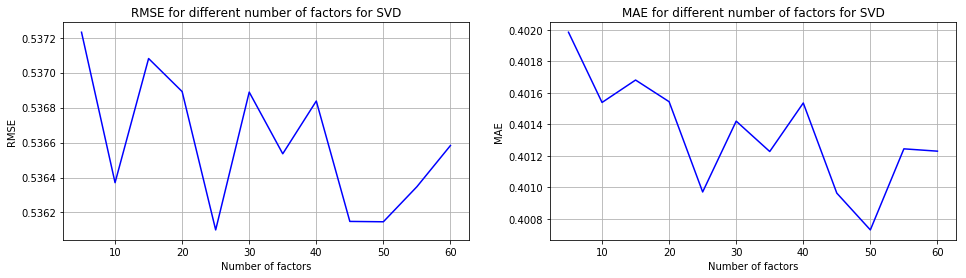

In [26]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(svd_factors.param_n_factors,svd_factors.mean_test_rmse, 'b')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='RMSE for different number of factors for SVD')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(svd_factors.param_n_factors,svd_factors.mean_test_mae, 'b')
ax2.set(xlabel='Number of factors', ylabel='MAE', title='MAE for different number of factors for SVD')
ax2.grid()

plt.show()

The RMSE for SVD seems to be less for number of factors equal to 25 and MAE is less when number of factors are 50. We will take 25 as number of latent factors.


<h2>Comparision of NMF and SVD algorithms </h2>

Lets check how the performance of the 2 algorithms examined so far compares with each other for different numbers of factors.

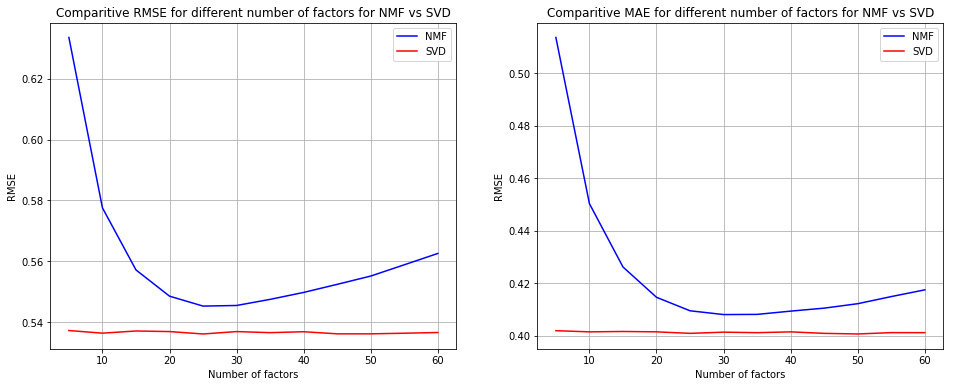

In [27]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.plot(nmf_factors.param_n_factors, nmf_factors.mean_test_rmse, 'b', 
         svd_factors.param_n_factors,svd_factors.mean_test_rmse, 'r')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='Comparitive RMSE for different number of factors for NMF vs SVD')
ax1.grid()
ax1.legend(['NMF',"SVD"])

ax2 = fig.add_subplot(122)
ax2.plot(nmf_factors.param_n_factors, nmf_factors.mean_test_mae, 'b',  
         svd_factors.param_n_factors, svd_factors.mean_test_mae, 'r')
ax2.set(xlabel='Number of factors', ylabel='RMSE', title='Comparitive MAE for different number of factors for NMF vs SVD')
ax2.grid()
ax2.legend(['NMF',"SVD"])


plt.show()

The graphs show that SVD has lower RMSE and MAE for any number of factors between 5 and 60. We conclude that SVD does a better job at predicting unobserved beer ratings than NMF.

<h2>Top ten recommendation</h2>
Given a user, output the top ten recommended beers for that user. 
Given that our analysis shows the SVD performs better at predicting unobserved beer ratings, we will use SVD for the task.

In [29]:
from collections import defaultdict

training_set = data.build_full_trainset()
algo = SVD(n_factors = 30, lr_all = 0.01, reg_all = 0.05)
algo.fit(training_set)
unfilled = training_set.build_anti_testset()
recommendation = algo.test(unfilled)

top_10 = defaultdict(list)
for uid, iid, u_id, est, details in recommendation:
    top_10[uid].append((iid, est))
for uid, user_ratings in top_10.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_10[uid] = user_ratings[:10]





In [166]:
#To Predict for given user
def predict_for_user(user):
    for uid, user_ratings in top_10.items():
        if (str(uid) == str(user)):
            print("The top 10 recommendations for" + str(uid) +  " are\n")
            for (iid, details) in user_ratings:
                print("- " + iid)

In [167]:
# Predicting for a particular user
predict_for_user(" Jason")


The top 10 recommendations for Jason are

-  TrÃ¶egs Nugget Nectar
-  Founders KBS (Kentucky Breakfast Stout)
-  Founders Breakfast Stout
-  Bell's Hopslam Ale
-  Chimay Grande RÃ©serve (Blue)
-  PÃ©chÃ© Mortel (Imperial Stout Au Cafe)
-  Franziskaner Hefe-Weisse
-  Hennepin (Farmhouse Saison)
-  Hop Stoopid
-  Ten FIDY


In [165]:
# Predicting for all the users, 
def give_all_recommendations():
    for uid, user_ratings in top_10.items():
        print(uid, [iid for (iid, details) in user_ratings])


<h2>Scaling</h2>

How do both SVD and NMF alogrithm scale with number of users and number of items? 

<h3> Number of Items</h3>
First we will try increase number of items by keeping number of users constant 1000.

In [128]:
# Setting up dataset for the scalability test fo items

# keep top 1000/33382 frequent users
user = data2.review_profileName.value_counts()
user_list = user.keys()[:1000].tolist()

# For a list of lists of top items
beer = data2.beer_name.value_counts()
beer_list[0] = beer.keys()[:100].tolist()
beer_list[1] = beer.keys()[:200].tolist()
beer_list[2] = beer.keys()[:300].tolist()
beer_list[3] = beer.keys()[:400].tolist()
beer_list[4] = beer.keys()[:500].tolist()

# keep (beer&user) pair in (user_list) and (beer_list) for varied number of items
subdata = {} 
for i in range(5):
    subdata[i] = data2[data2.beer_name.isin(beer_list[i])]
    subdata[i] = subdata[i][subdata[i].review_profileName.isin(user_list)]

In [129]:
# Convert data into required form
data_clean = {}
for i in range(5):
    data_clean[i] = subdata[i].sort_values(by='review_time')
    data_clean[i].drop_duplicates(['beer_name', 'review_profileName'], keep = 'last', inplace = True)
    data_clean[i]['review_overall'] = data_clean[i]['review_overall'].astype(float)

    
reader = Reader(rating_scale=(1, 5))
data = {}
for i in range(5):
    data[i] = Dataset.load_from_df(data_clean[i][['review_profileName', 'beer_name', 'review_overall']], reader)

In [130]:
# SVD algorithm for varied number of items (With optimal Hyper parameters)
import time
param_grid = {'n_factors': [25], 'n_epochs': [50], 'lr_all': [0.01], 'reg_all': [0.05]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 5)
svd_time_scores = {}
for i in range(5):
    start = time.time()
    grid_search_svd.fit(data[i])
    end = time.time()
    svd_time_scores[str(len(item_list[i]))] = end - start

#NMF algorithm for varied number of items (With optimal Hyper parameters)
param_grid = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
nmf_time_scores = {}
for i in range(5):
    start = time.time()
    grid_search_nmf.fit(data[i])
    end = time.time()
    nmf_time_scores[str(len(item_list[i]))] = end - start


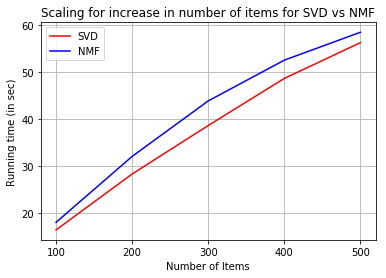

In [168]:
# Plot for SVD vs NMF
fig, ax = plt.subplots()
ax.plot(svd_time_scores.keys(), svd_time_scores.values(),  'r',
       nmf_time_scores.keys(), nmf_time_scores.values(),  'b',)
ax.set(xlabel='Number of Items', ylabel='Running time (in sec)', 
       title='Scaling for increase in number of items for SVD vs NMF')
ax.grid()
ax.legend(['SVD',"NMF"])

plt.show()

The above graph shows that SVD scales linearly in time with increase in number of items. Also, though NMF scales linearly too, the time taken by NMF is always higher than time taken by SVD

<h3> Number of Users</h3>
First we will try increase number of users by keeping number of items constant 100.  

In [132]:
# Setting up dataset for the scalability test for users

# For a list of lists of top users
user = data2.review_profileName.value_counts()
user_list[0] = user.keys()[:1000].tolist()
user_list[1] = user.keys()[:1500].tolist()
user_list[2] = user.keys()[:2000].tolist()
user_list[3] = user.keys()[:2500].tolist()
user_list[4] = user.keys()[:3000].tolist()

# keep top x * 100/56855 most reviewed beer
beer = data2.beer_name.value_counts()
beer_list = beer.keys()[:100].tolist()

# keep (beer&user) pair in (user_list) and (beer_list) for varying number of users
subdata = {} 
for i in range(5):
    subdata[i] = data2[data2.beer_name.isin(beer_list)]
    subdata[i] = subdata[i][subdata[i].review_profileName.isin(user_list[i])]

In [133]:
# Converting data into required format
data_clean = {}
for i in range(5):
    data_clean[i] = subdata[i].sort_values(by='review_time')
    data_clean[i].drop_duplicates(['beer_name', 'review_profileName'], keep = 'last', inplace = True)
    data_clean[i]['review_overall'] = data_clean[i]['review_overall'].astype(float)

    
reader = Reader(rating_scale=(1, 5))
data = {}
for i in range(5):
    data[i] = Dataset.load_from_df(data_clean[i][['review_profileName', 'beer_name', 'review_overall']], reader)

In [134]:
# SVD algorithm for varied number of users (With optimal Hyper parameters)
import time
param_grid = {'n_factors': [25], 'n_epochs': [50], 'lr_all': [0.01], 'reg_all': [0.05]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 5)
svd_user_time_scores = {}
for i in range(5):
    start = time.time()
    grid_search_svd.fit(data[i])
    end = time.time()
    svd_user_time_scores[str(len(user_list[i]))] = end - start

# NMF algorithm for varied number of users (With optimal Hyper parameters)
param_grid = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
nmf_user_time_scores = {}
for i in range(5):
    start = time.time()
    grid_search_nmf.fit(data[i])
    end = time.time()
    nmf_user_time_scores[str(len(user_list[i])))] = end - start

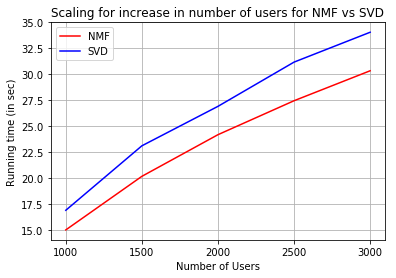

In [169]:
fig, ax = plt.subplots()
ax.plot(svd_user_time_scores.keys(), svd_user_time_scores.values(),  'r',
       nmf_user_time_scores.keys(), nmf_user_time_scores.values(),  'b',)
ax.set(xlabel='Number of Users', ylabel='Running time (in sec)', 
       title='Scaling for increase in number of users for NMF vs SVD')
ax.grid()
ax.legend(['NMF',"SVD"])
plt.show()

Similar to the increase in items, the above graph shows that SVD scales linearly in time with increase in number of users. Also, though NMF scales linearly too, the time taken by NMF is always higher than time taken by SVD.